# 1D QUBIC
### JCH - Feb. 2025

This notebook and associated library `qubic/lib/Q1d.py` are investigating a 1 dimensional version of QUBIC, where the synthesized beam and sky are restricted to 1D. Although useless for practical use, this is atool that will allow us to investigate a number of interesting issues related to sky reconstruction as one can brute force inverse the matrices in that case.

We can for instance check for specifiec issues such as:
- reconstructed sky pixellization w.r.t. actual smooth sky
- comparison between and imager and B.I.
- study of the effect of the ripples in the synthesized beam and actual shape of the synthesized beam peaks, while our reconstruction algorithms rely for now on the so-called "Gaussian Peak Approxmmation" (GPA) in which the synthesized beam is simplified at reconstructed stage by a series of gaussians.
- alternative reconstruction techniques to be investigated (such as the synthesized beam factorization proposed in 2024 by Victor Chabirand)
- other things for sure...


## Mandatory imports
`qubic/lib/Q1d.py` is the library that is used by this notebook.


In [1]:
%matplotlib ipympl


import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.signal
from importlib import reload    

from qubic.lib import Q1d as q1d 

sz = 10.
plt.rc('figure',figsize=(sz,sz/1.618))
plt.rc('font',size=10)
plt.rc('image', cmap='jet')

## Investigation of the various Instruments models
Currently, three instrument models are implemented:
- a perfect imager, with a perfect gaussian as the synthesized beam
- a theoretical bolometric interferometer where the synthesized beam (for TOD fabrication) is modelled as a theoretcal B.I. in 1D, taken from Eq. 2.7 from QUBIC II paper (https://arxiv.org/pdf/2010.15119).
- a BI approximmated by the Gaussian Peak approximmation.

The various parameters are transmitted through the `params` dictionary for which a default version can be found in the `qubic/lib/Q1d.py` and then modified in the current notebook. 

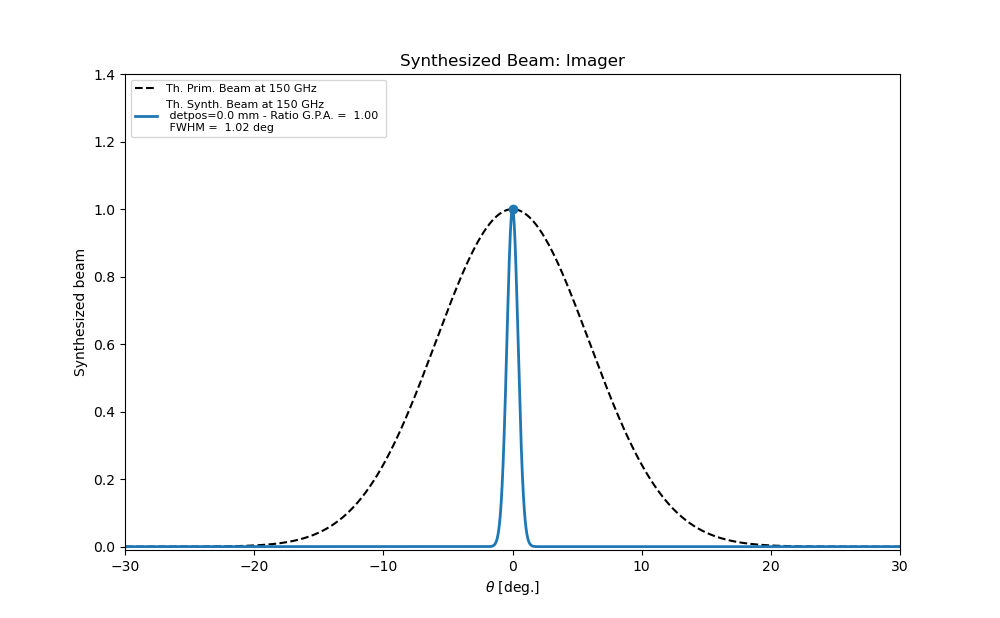

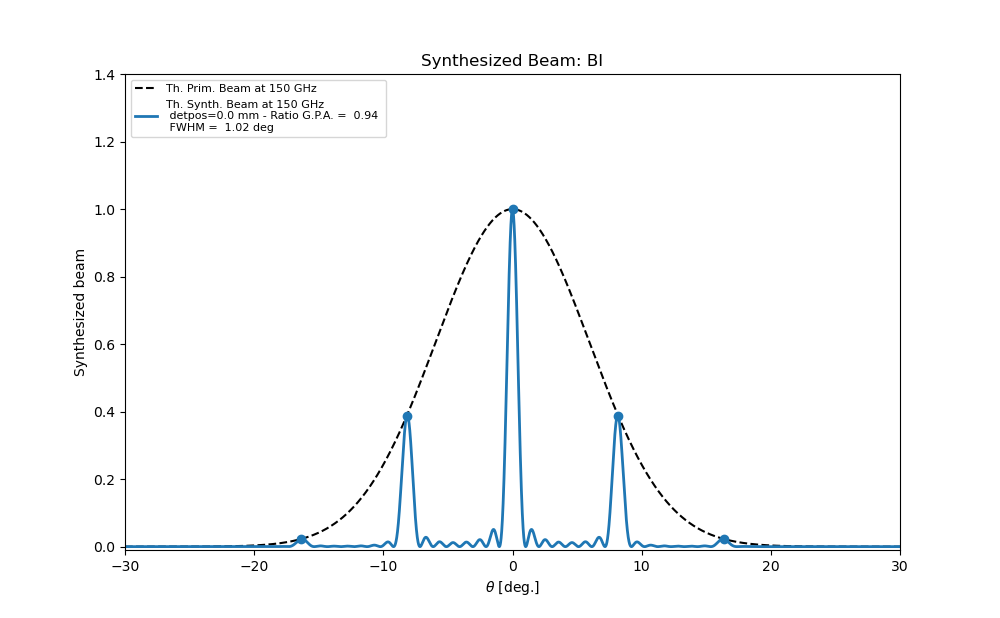

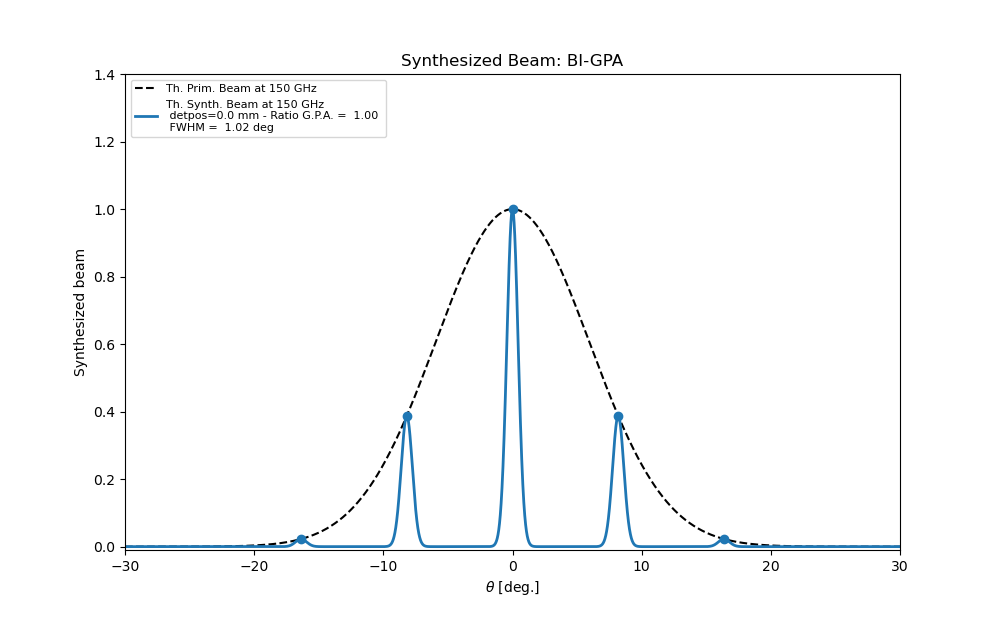

In [2]:
reload(q1d)

inst = q1d.Q1D(instrument_type='Imager')
inst = q1d.Q1D(instrument_type='BI')
inst = q1d.Q1D(instrument_type='BI-GPA')

## Simulation subtle effects:

Below we perform the TOD creation and recnstruction in a single call. When setting the noise to zero, and simulating data (TOD creation) in a consistent manner with the reconstruction model, we see zero bias for the three instrument configurations (Imager, BI and BI-GPA): they all lead to $\sim 10^{-15}$ residuals, consistent with numerical noise.

#### TOD fabrication realism:
An important parameter is the `TOD_method` one, it realtes to how realistically we construct our TODs. It can take the follwing values:
- `exact`: The instrument sees the sky throuugh the synthesized beam, therefore an exact TOD can be calculated in the following manner: we first convolve the sky with the full shape of the synthesized beam (be it modeled as an imager, a BI or a BI-GPA), then convolve it with the reconstructed pixels window function and then pick values at the pointing locations to form the TODs. The issue with this technique is that is is "too realistic" with respect to our reconstruction procedure that is based on modeling the sky through H which goes from TOD to a pixellized sky. In 2D, with Healpix maps, we usually form the simulated TODs from a map that is pixellized at the same size as the reconstructed map, so this effect is absorbed. With real data, this is what the instrument does, so this mismatch, although probably very small, should be there.
- `approx`: here we solve the above issue by constructing the TODs in the same fashion as with H, but "by hand": we first convolve the input sky with the angular resolution (not the multi-peaked synthesized beam) and the reconstructed pixels window function, we then pixellize this to the reconstructed pixellization (using interpolation). We then get the pixel numbers for each peack and build the TOD by summing those multiplied by the amplitude of each peak. This is what one usually does with 2D simulations.
- `approx_Hd`: we directly do the same as for `approx` but simply applying H to the resolution + reconstructed pixels window function convolved sky. It should be strictly equivalent (within numerical errors) to `approx`.

For now, in this notebook, I suggest to stay with `approx` and investigate the effects of TOD fabrication realism in another notebook. In brief, in the `exact` case, the pointing will pick a number of pointing locations falling into a given reconstruction pixel (or a collection of reconstructed pixels in the case of B.I.), the reconstructed pixel value will be a combination of those picked values. This is exactly what an actual instrument does. However, when comparing with the expected truth, which is estimated independently of the poinitng, we assume a value for the reconstructed pixel which is the mathematical average of all picked values in the pixel. But for a finite number of pointings, the empirical average (obtained when reconstructing with inverting the H equation) will never reach the mathematical average and will always fluctuate around it. This results in a kind of "poinitng sample variance". The efect is large for a low number of pointings but will gradually vanish for a large number of pointings. In realistic observation cases, it is very likely to be absolutely negligible (becasue of the large number of pointings and even further due to the measurement noise that will largely dominate in general). As a result it appears as a good approximmation to use instead the `approx` method for building TODs, as it will lead to a TOD for which reconstruction will lead to the mathematical average and therefore zero residuals. 

##### Remarks: 
- this TOD realism issue applies to an imager in the same fasion as for a BI.
- When using the `approx` method, it is impossible to account for the ripples in the B.I. synthesized beam by construction. As a result, the effect of these ripples cannot be assessed, this can only be done using the `exact` method and will therefore be mixed with the TOD-realism related effects.


#### Random seeds
There are parameters for setting seeds for the three random processes involved here. If set to `None` the seed will be different each time, if set to some integer, the random process will always follow the same suite.

```
# Seeds ################################################################################
params['sky_seed']           = 1                    # Seed for the sky simulation
params['pointing_seed']      = 1                    # Seed for the pointing
params['noise_seed']         = None                 # Seed for the noise
```

## Let's run the simulation step by step !

### Instantiate instrument

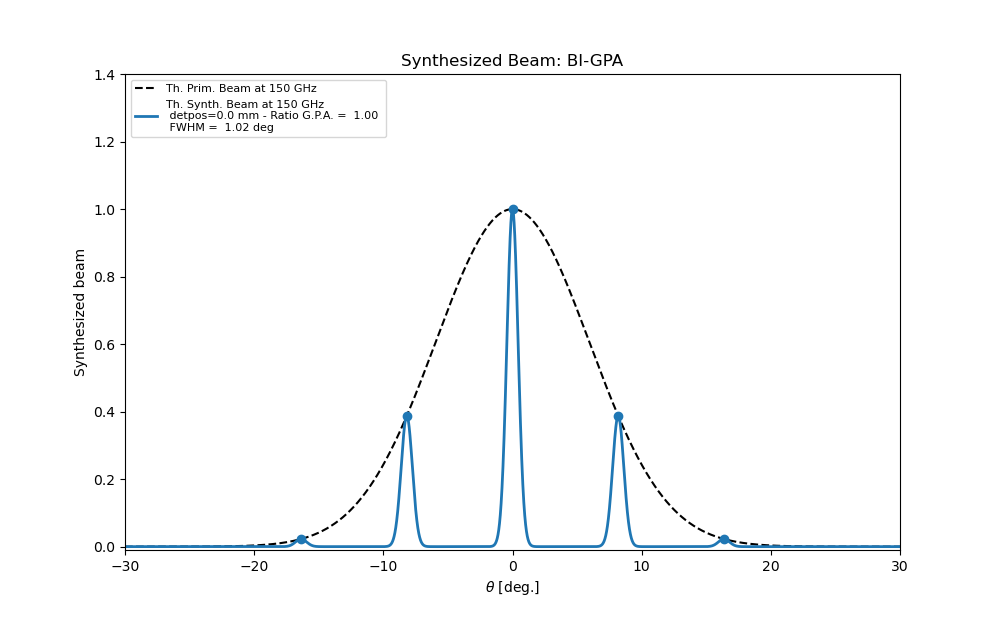

In [3]:
inst = q1d.Q1D(instrument_type='BI-GPA')

### Create true sky

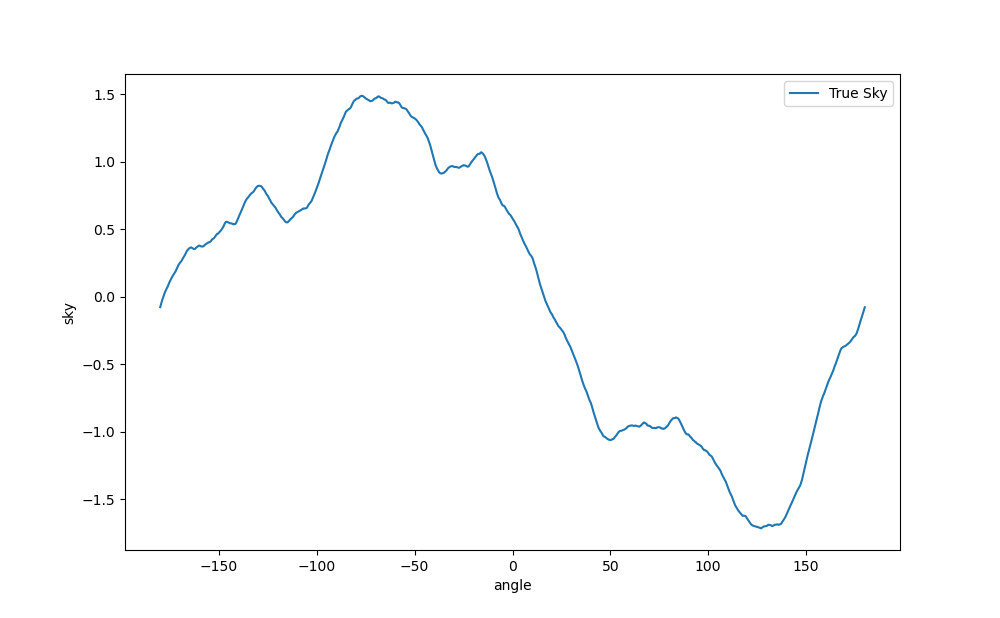

In [4]:
inst.plot_sky = True
inst.sky_seed = 1
inst.create_sky()

### Compute theoretical prediction for the pixellized reconstructed signal

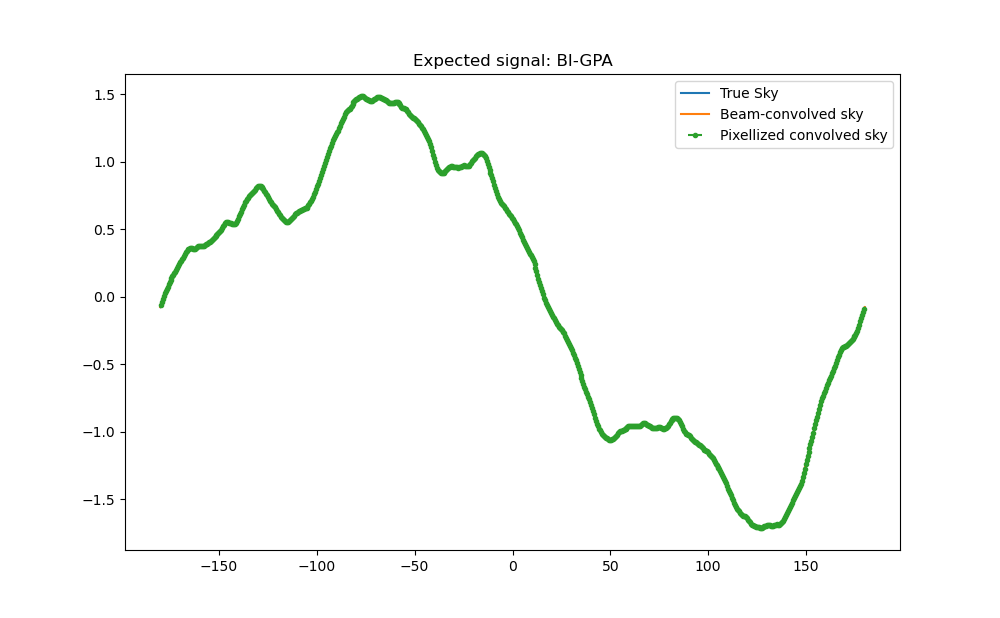

In [5]:
# Compute theoretical predictions for the reconstructed sky
inst.plot_expected = True
inst.compute_expected_sky()

### Pointing

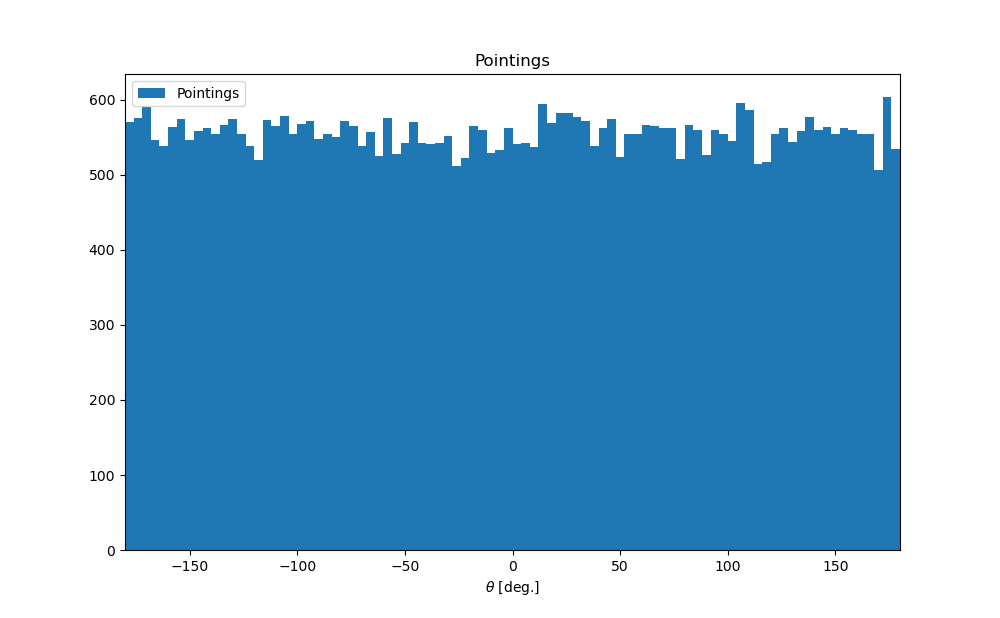

In [6]:
# Generate random pointing directions
inst.plot_pointings = True
inst.generate_pointings()

### Generate TODs

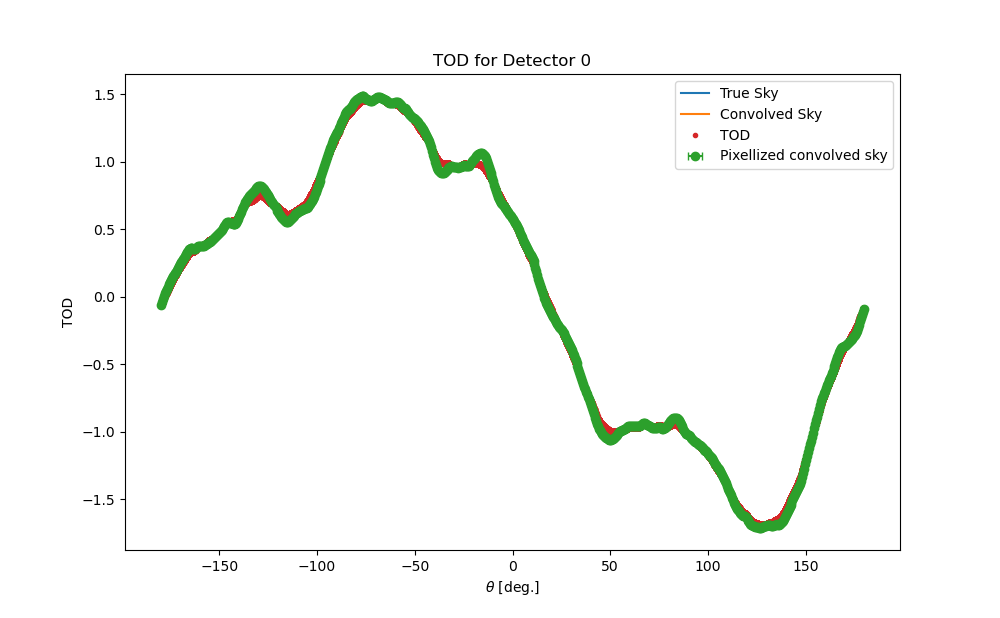

In [7]:
# Generate TOD
inst.TOD_method = 'approx'
inst.plot_TOD = True
inst.build_TOD()

### H operator

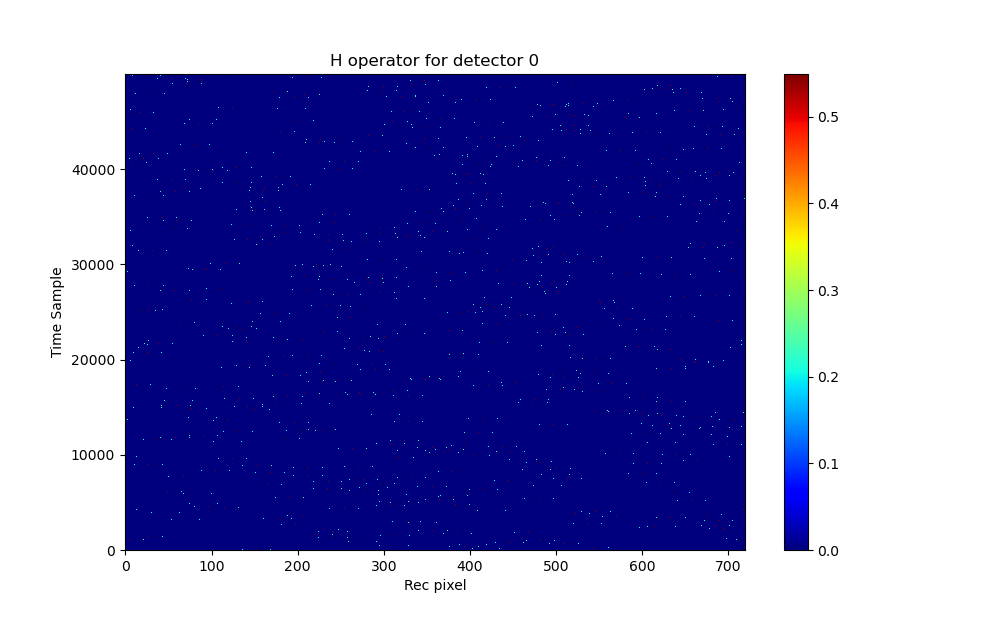

In [8]:
# Compute H operator
inst.plot_H = True
inst.build_H_operator(inst.kmax_rec)

### Compute $H^t\cdot H$, its inverse and the solution

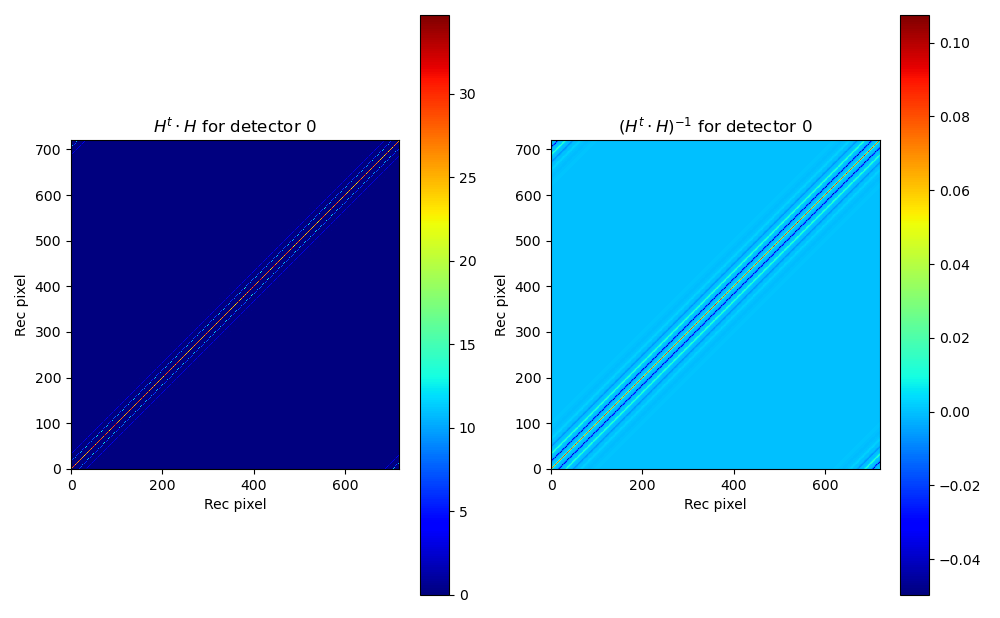

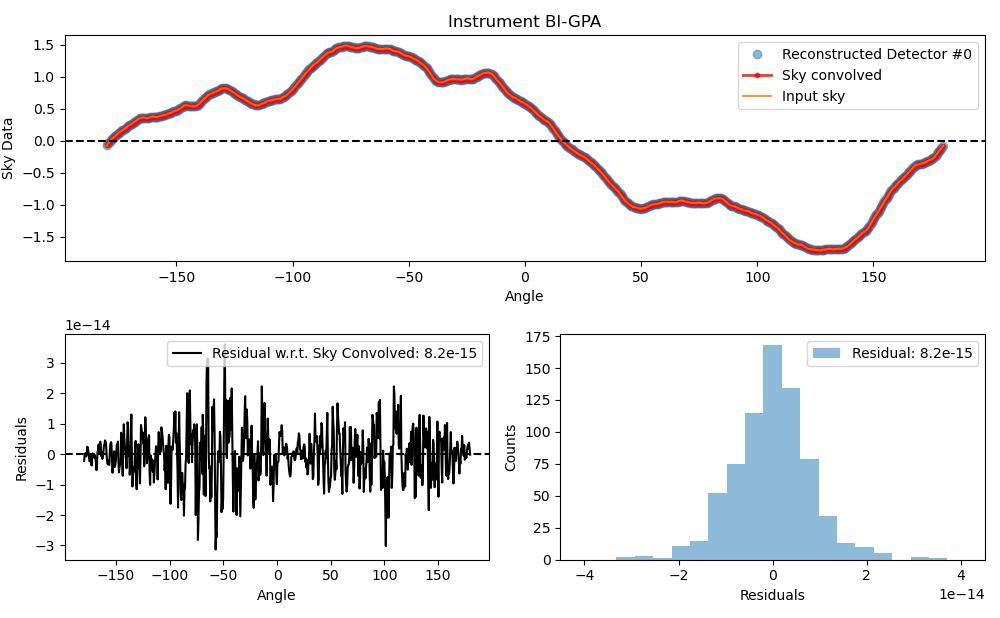

In [9]:
# Compute solution
reload(q1d)
inst.plot_HtH = True
inst.plot_reconstructed = True
mysolution, mysolution_all = inst.mapmaking_solution(inst.H, inst.TOD)

## Full simulation in a row
One can directly run everything and reconver the data using the following:

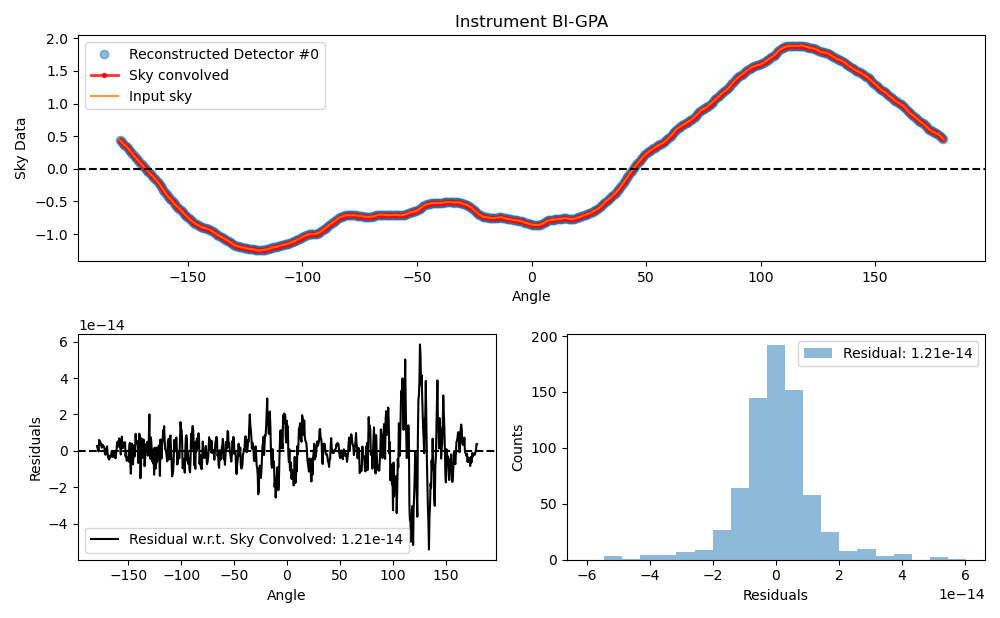

In [11]:
reload(q1d)

# Instanciate
params = {'plot_sb': False, 'plot_reconstructed': True, 'pointing_seed':None, 'sky_seed': None}
inst = q1d.Q1D(instrument_type='BI-GPA', params=params)
results = inst.simulate_and_reconstruct()

## Small Monte-Carlo simulation
We can now easily perform a Monte-Carlo simulation in order to investgate various effects.

Realization 0 9.31046273742727e-15
Realization 1 1.2422378843294193e-14
Realization 2 9.548553129019521e-15
Realization 3 8.826417117901829e-15
Realization 4 1.0213039610866193e-14
Realization 5 7.88970693843151e-15
Realization 6 1.1525355962672614e-14
Realization 7 1.0147199334023461e-14
Realization 8 1.517984801844138e-14
Realization 9 1.0109661284038435e-14


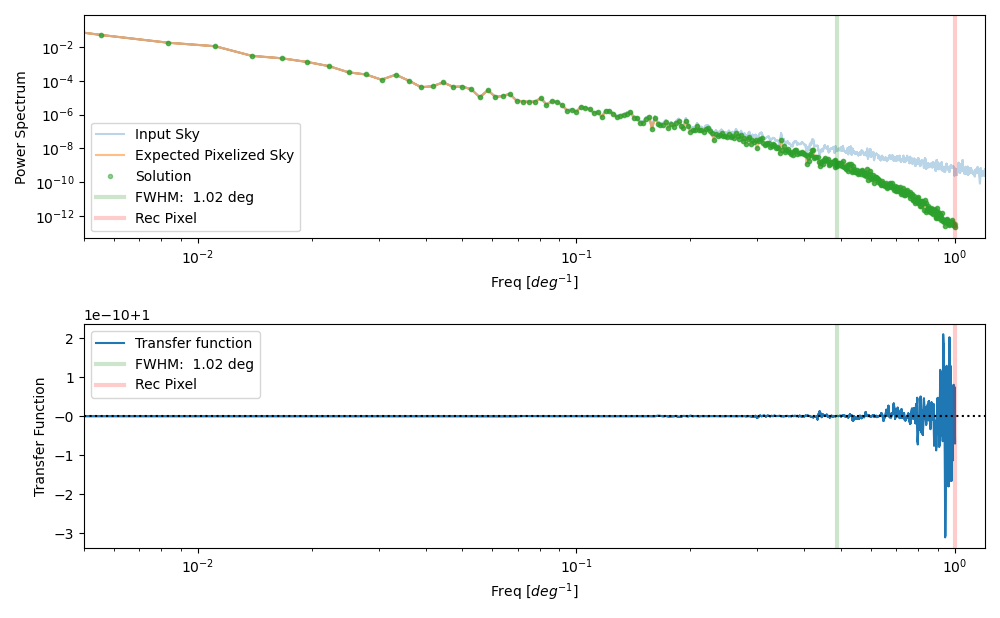

In [12]:
reload(q1d)
params = {'plot_sb': False, 
          'plot_reconstructed': False,
          'sky_seed': None,
          'pointing_seed': None,
          'noise_seed': None,
          'noise_rms':0}
inst = q1d.Q1D(instrument_type='BI-GPA', params=params)

nn = 10

all_ps_sky = np.zeros((nn, inst.npix_sky))
all_ps_sky_pix = np.zeros((nn, inst.npix))
all_ps_solution = np.zeros((nn, inst.npix))


for i in range(nn):
    results = inst.simulate_and_reconstruct()
    print('Realization {}'.format(i), results['RMS_resall'])
    
    freq_pix = np.abs(np.fft.fftfreq(len(inst.rec_pix_centers), d=inst.rec_pix_centers[1]-inst.rec_pix_centers[0]))
    all_ps_sky_pix[i,:] = np.abs(np.fft.fft(inst.convolved_sky_pix))**2 / len(inst.rec_pix_centers)**2
    all_ps_solution[i,:] = np.abs(np.fft.fft(results['solution_all']))**2  / len(inst.rec_pix_centers) **2

    freq_sky = np.abs(np.fft.fftfreq(inst.npix_sky, d=inst.input_sky[0][1]-inst.input_sky[0][0]))
    all_ps_sky[i,:] = np.abs(np.fft.fft(inst.input_sky[1]))**2 / inst.npix_sky**2
  

#### Power spectrum analysis

known_freqs = []
known_freqs.append({'label':'FWHM: {0:5.3g} deg'.format(inst.fwhmpeak[0]), 'freq': 1./(inst.fwhmpeak[0])/2, 'color':'g', 'ls':'-', 'lw': 3, 'nbharm': 1})
known_freqs.append({'label':'Rec Pixel', 'freq': 1./(inst.rec_pix_centers[1]-inst.rec_pix_centers[0])/2, 'color':'r', 'ls':'-', 'lw': 3, 'nbharm': 1 })

aa = 0.2
harm_max=50

plt.figure()
plt.subplot(2,1,1)
plt.plot(freq_sky, np.mean(all_ps_sky, axis=0), label='Input Sky', alpha=0.3)
plt.plot(freq_pix, np.mean(all_ps_sky_pix, axis=0), alpha=0.5, label='Expected Pixelized Sky')
plt.plot(freq_pix, np.mean(all_ps_solution, axis=0), '.', alpha=0.5, label='Solution')
for fff in known_freqs:
    p=plt.axvline(x = fff['freq'], ls=fff['ls'], lw=fff['lw'], alpha=aa, label=fff['label'], color=fff['color'])
    for i in range(2,fff['nbharm']):
        plt.axvline(x = i * fff['freq'], ls=fff['ls'], lw=fff['lw'], color=fff['color'], alpha=aa)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Freq [$deg^{-1}$]')
plt.ylabel('Power Spectrum')
plt.xlim(5e-3, np.max(freq_pix)*1.2)
plt.ylim(np.min(np.mean(all_ps_solution, axis=0))/5, np.max(np.mean(all_ps_solution, axis=0))*2)
plt.legend()

plt.subplot(2,1,2)
plt.plot(freq_pix, np.mean(all_ps_solution, axis=0) / np.mean(all_ps_sky_pix, axis=0), label='Transfer function')
plt.axhline(y=1, ls=':', color='k')
for fff in known_freqs:
    p=plt.axvline(x = fff['freq'], ls=fff['ls'], lw=fff['lw'], alpha=aa, label=fff['label'], color=fff['color'])
    for i in range(2,fff['nbharm']):
        plt.axvline(x = i * fff['freq'], ls=fff['ls'], lw=fff['lw'], color=fff['color'], alpha=aa)
plt.xscale('log')
plt.xlabel('Freq [$deg^{-1}$]')
plt.ylabel('Transfer Function')
plt.xlim(5e-3, np.max(freq_pix)*1.2)
plt.legend()
plt.tight_layout()


# A list of things to test with the 1D model:
- TOD Realism: see the notebook `Q1D-TOD-Realism.ipynb`
- Gaussian Peak Approximmation Vs real Synthesized beam: see the notebook `Q1D-GaussianPeakApproximation.ipynb` (work in progress)
- Simulating with many peaks (large kmax) and reconstruction with less (to be done)
- Effect of systematic errors on the actual location, amplitude, width of the peaks modeling
- novel implementations of the map-making (diagonalized version proposed by Victor Chabirand)

It would also be interesting to implement it with the full bandwidth and try spectral-imaging in 1D (FMM or CMM), and possibly the atmosphere mitigation.